# Диффузионные модели

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/puhsu/dl-hse/tree/main/2024/hw04-bonus-diffusion/notebook.ipynb)

#### Разработчик: Аким Котельников

План задания: пишем свою диффузионную модель и тестируем её на SwissRoll-ах (60% баллов), далее запускаем её на MNIST (20%), затем пишем DDIM и проверям его на MNIST (20%). Цель задания: разобраться как работают диффузионные модели, разобраться в формулах. При этом проблем с обучением моделей почти быть не должно. Формат: дозаполнить "todo".

### Импорты и SwissRoll-ы

In [1]:
!wget --quiet --show-progress "https://raw.githubusercontent.com/puhsu/dl-hse/main/2024/hw04-bonus-diffusion/utils.py"

utils.py            100%[===================>]   6.55K  --.-KB/s    in 0s      


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_swiss_roll
from sklearn.utils import shuffle

In [4]:
SEED = 777

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [5]:
from sklearn.datasets import make_circles, make_swiss_roll


def make_swiss_dataset(num_samples):
    X0, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X1, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X0 = X0[:, [0, 2]]
    X1 = X1[:, [0, 2]]
    X1 = -X1
    X, y = shuffle(
        np.concatenate([X0, X1], axis=0),
        np.concatenate([np.zeros(len(X0)), np.ones(len(X1))], axis=0),
        random_state=0,
    )
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    return X, y


X, y = make_swiss_dataset(2000)

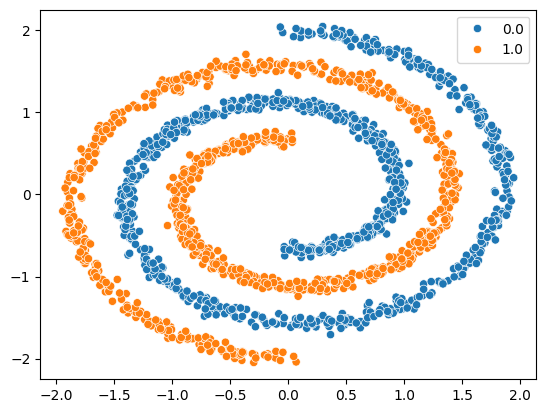

In [6]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y);

## DDPM (0.6 баллов)

В данной части вам предстоит написать собстевнную диффузионную модель (DDPM) и протестировать её на датасете выше.

### Напоминание

Напомним, что диффузионная модель состоит из прямого и обратного процесса. Прямой диффузионный процесс определяется как апостериорное распределение $q(x_{1:T}|x_0)$. Это распределение также является Марковской цепочкой, которая постепенно добавляет гауссовский шум к данному начальному объекту $x_0$. На каждом шаге шум добавляется с различной магнитудой, которая определяется расписанием дисперсий
 $\{\beta_1, ... \beta_T\}$. При правильном выборе расписания в пределе по числу шагов $T$ мы должны сойтись к шуму из $\mathcal{N}(0, I)$. В качестве распределений $q$ берут нормальные распределения:
$$
 q(x_t | x_{t - 1}) := \mathcal{N}(x_t; \sqrt{1 - \beta_t}x_{t - 1}, \beta_tI), \ \ \ \ \ \ \ q(x_{1:T}|x_0) = \prod_{t = 1}^T q(x_t | x_{t - 1})
$$

Теперь посмотрим со стороны обратного процесса. Обратный процесс расшумляет шум, пока не получится объект из изначального распределения. Таким образом, диффузионная модель - это вероятностная модель с латентными переменными вида $p_\theta(x_0) := \int p_\theta(x_{0:T}) dx_{1:T}$, где промежуточные состояния $x_1, ..., x_T$ соответствуют зашумленным объектам, a $x_0$ - объект из распределения. Совместное распределение $p_\theta(x_{0:T})$ называет обратным диффузионным процессом, который представляет собой Марковскую цепочку из гауссовских распределений $p_\theta(x_{i-1}|x_{i})$:

$$
p(x_{0:T}) = p(x_0) \prod_{t = 1}^Tp_{\theta}(x_{t-1}|x_t) \ \ \ \ \ \ \ \ \ p_\theta(x_{T})=\mathcal{N}(x_T | 0, I)
$$
$$
  p_{\theta}(x_{t - 1}|x_t):= \mathcal{N}(x_{t - 1}; \mu_{\theta}(x_t, t), \Sigma_{\theta}(x_t, t))
$$

Вернемся к распределению $q(x_t | x_{t - 1})$.  Для того чтобы получить $x_t$, придется итеративно получать $x_1, ..., x_{t - 1}$. Однако это можно сделать более эффективно благодаря нормальным распределениям. Для этого обозначим $\alpha_t := 1- \beta_t$ и $\bar{\alpha}_t:= \prod_{i = 1}^t\alpha_i$, тогда
$$
q(x_t | x_0) = \mathcal{N}(x_t;\sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t)I) \quad \quad \quad \quad \quad \quad (1)
$$

Затем модель можно обучать, оптимизируя отдельные члены суммы вариационной нижней оценки $\log p_{\theta}(x_0)$:
$$
L_{VLB} = \mathbb{E}_q [\underbrace{D_\text{KL}(q(\mathbf{x}_T |
\mathbf{x}_0) \parallel p_\theta(\mathbf{x}_T))}_{L_T} + + \sum_{t=2}^T
\underbrace{D_\text{KL}(q(\mathbf{x}_{t-1} | \mathbf{x}_t,
\mathbf{x}_0) \parallel p_\theta(\mathbf{x}_{t-1}
| \mathbf{x}_t))}_{L_{t-1}} \underbrace{- \log p_\theta(\mathbf{x}_0
| \mathbf{x}_1)}_{L_0}
$$

Для обучение нужно лишь выписать $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \mathbf{I}) $:

$$
    \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} \mathbf{x}_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} \mathbf{x}_0 \ \ \ \ \ \ (2)
$$
$$
    \tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t  \quad \quad \quad \quad \quad \quad \quad (3)
$$


За подробностями читайте статью [Denoising Diffusion Probabilistic Models (Ho et al. 2020)](https://arxiv.org/abs/2006.11239).

Тем не менее в упомянутой статье было показано, что обучаясь на более простой лосс, получаются результаты лучше.  

Итак, заметим, что
$$
x_t(x_0, \epsilon) = \sqrt{\bar{\alpha}_t} x_0 +  \sqrt{1-\bar{\alpha}_t}\epsilon, \ \ \ \epsilon \sim \mathcal{N}(0, I) \quad \quad \quad \quad \quad \quad \quad (4)
$$

Тогда пускай наша модель с весами $\theta$ будет предсказывать $\epsilon$ из равенства выше, а именно обучаться, минимизируя данную функцию потерь:

$$L^{simple}_t = \mathbb{E}_{x_0, \epsilon, t}\bigg[ \|\epsilon - \epsilon_{\theta}(x_t, t)\|^2\bigg]$$

Смысл в том, что KL между нормальными распределениями порпорционален квадрату разницы между их средними, а средние в нашем случае параметризуются через $\epsilon$, поэтому это работает.

Именно этот лосс вы должны будете использовать.


Чтобы сэмплировать (обратный процесс), нам нужно получить $\mu_{\theta}(x_t, x_0)$ из $\epsilon_{\theta}(x_t, t)$. Для этого получите $\hat{x}_0(\epsilon_{\theta}, x_t)$ из уравнения (4) и подставьте его в равенство (2). Понадобится для реализации _predict_xstart_from_eps.

Переходим к заданию. Ниже будут представлены две вспомогательные функции, которые вам понадобятся.

In [7]:
# some functions you will need

import math


# utility function. basically, returns arr[timesteps], where timesteps are indices. (look at class Diffusion)
def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D torch tensor for a batch of indices.
    :param arr: 1-D torch tensor.
    :param timesteps: a tensor of indices into torch array to extract. (shape is [batch_size])
    :param broadcast_shape: a larger shape of K dimensions; output shape will be broadcasted to this
                            by adding new dimensions of size 1.
                            the first dimension of output tensor will be equal to length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where tensor shape has K dims.
    """
    res = arr.to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)


# our beta_t. we use linear scheduler
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    scale = 1000 / num_diffusion_timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "quad":
        betas = (
            torch.linspace(beta_start**0.5, beta_end**0.5, num_diffusion_timesteps) ** 2
        )
        return betas.numpy()
    elif schedule_name == "sigmoid":
        betas = torch.linspace(-6, 6, num_diffusion_timesteps)
        betas = torch.sigmoid(betas) * (beta_end - beta_start) + beta_start
        return betas.numpy()
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")

### Класс Diffusion (0.4 балла из 0.6 за DDPM)
Вам нужно дописать недостающие части ниже (помечены todo).

In [8]:
from tqdm import tqdm

class Diffusion:
    def __init__(
        self,
        *,
        betas: np.ndarray, # type: ignore
        loss_type: str = "mse"
    ):
        """
        Class that simulates Diffusion process. Does not store model or optimizer.
        """
        self.loss_type = loss_type

        betas = torch.from_numpy(betas).double()
        self.betas = betas
        assert len(betas.shape) == 1, "betas must be 1-D"
        assert (betas > 0).all() and (betas <= 1).all()

        self.num_timesteps = int(betas.shape[0])

        alphas = 1.0 - betas # todo
        self.alphas_cumprod = torch.cumprod(alphas, dim=0) # todo
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), self.alphas_cumprod[:-1]], dim=0)  # \bar\alpha_{t-1}
        self.alphas_cumprod_next = torch.cat([self.alphas_cumprod[1:], torch.tensor([0.0]), ], dim=0)  # \bar\alpha_{t+1}
        assert self.alphas_cumprod_prev.shape == (self.num_timesteps,)

        # calculations for diffusion q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = self.alphas_cumprod.sqrt()
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)


        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = ((1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)) * betas # todo, var from (3)

        # log calculation clipped because posterior variance is 0.
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]], dim=0)
        )
        self.posterior_mean_coef1 = (torch.sqrt(alphas) * (1.0 - self.alphas_cumprod_prev)) / (1.0 - self.alphas_cumprod) # todo, coef of xt from (2)
        self.posterior_mean_coef2 = torch.sqrt(self.alphas_cumprod_prev) * self.betas / (1.0 - self.alphas_cumprod) # todo, coef of x0 from (2)

    def q_mean_variance(self, x0, t):
        """
        Get mean and variance of distribution q(x_t | x_0) for specific x_0 and t. Use equation (1).
        """

        mean = _extract_into_tensor(self.sqrt_alphas_cumprod, t, x0.shape) * x0 # todo ; use _extract_into_tensor(*, t, x0.shape) function here and below for getting specific value from *alphas* array
        variance = _extract_into_tensor(1.0 - self.alphas_cumprod, t, x0.shape) # todo
        log_variance = _extract_into_tensor(self.log_one_minus_alphas_cumprod, t, x0.shape) # todo
        return mean, variance, log_variance

    def q_posterior_mean_variance(self, x_start, x_t, t):
        """
        Compute mean and variance of diffusion posterior q(x_{t-1} | x_t, x_0) for specific x_t and t.
        Use equation (2) and (3).

        x_start is x_0 in formulas
        """
        assert x_start.shape == x_t.shape
        posterior_mean = _extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape) * x_t + \
                         _extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape) * x_start # todo
        posterior_variance = _extract_into_tensor(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = _extract_into_tensor(
            self.posterior_log_variance_clipped, t, x_t.shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def q_sample(self, x_start, t, noise=None):
        """
        Diffuse data for a given number of diffusion steps.
        Sample from q(x_t | x_0) use (4).
        """
        if noise is None:
            noise = torch.randn_like(x_start)
        return _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start + \
               _extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise # todo ############

    def _predict_xstart_from_eps(self, x_t, t, eps):
        """
        Get \hat{x0} from epsilon_{theta}. Use equation (4) to derive it.
        """
        # raise NotImplementedError
        return (_extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - \
                _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * eps) # todo

    def p_mean_variance(self, model_output, x, t):
        """
        Apply model to get p(x_{t-1} | x_t). Use Equation (2) and plug in \hat{x}_0;
        """
        model_variance = torch.cat([self.posterior_variance[1:2], self.betas[1:]], dim=0)
        model_log_variance = torch.log(model_variance)
        model_variance = _extract_into_tensor(model_variance, t, x.shape)
        model_log_variance = _extract_into_tensor(model_log_variance, t, x.shape)

        pred_xstart = self._predict_xstart_from_eps(x, t, model_output)
        posterior_mean1 = _extract_into_tensor(self.posterior_mean_coef1, t, x.shape)
        posterior_mean2 = _extract_into_tensor(self.posterior_mean_coef2, t, x.shape)

        model_mean = posterior_mean1 * x + posterior_mean2 * pred_xstart # todo ; don't forget to extract specific values from posterior_mean_coef1 and posterior_mean_coef2 using _extract_into_tensor

        return {
            "mean": model_mean,
            "variance": model_variance,
            "log_variance": model_log_variance,
            "pred_xstart": pred_xstart,
        }

    def p_sample(self, model_output, x, t):
        """
        Sample from p(x_{t-1} | x_t).
        """
        out = self.p_mean_variance(model_output, x, t) # todo; get mean, variance of p(xt-1|xt)
        noise = torch.randn_like(x)
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        )  # no noise when t == 0


        sample = out["mean"] + nonzero_mask * torch.exp(0.5 * out["log_variance"]) * noise
        return {"sample": sample}

    def p_sample_loop(self, model, shape, y_dist):
        """
        Samples a batch=shape[0] using diffusion model.
        """

        x = torch.randn(*shape, device=model.device)
        indices = list(range(self.num_timesteps))[::-1]

        y = torch.multinomial(
            y_dist,
            num_samples=shape[0],
            replacement=True
        ).to(x.device)

        for i in tqdm(indices):
            t = torch.tensor([i] * shape[0], device=x.device)
            with torch.no_grad():
                model_output = model(x, t, y)
                out = self.p_sample(
                    model_output,
                    x,
                    t
                )
                x = out["sample"]
        return x, y

    def train_loss(self, model, x0, y):
        """
        Calculates loss L^{simple}_t for the given model, x0.
        """
        t = torch.randint(0, self.num_timesteps, size=(x0.size(0),), device=x0.device)
        noise = torch.randn_like(x0) # todo: sample tensor of shape x0 with noise (from std normal distribution)
        x_t = self.q_sample(x0, t, noise=noise) # todo use q_sample() to get diffused samples with specific noise
        model_output = model(x_t, t, y) # todo; predict sampled noise from (x_t, t, y)
        if self.loss_type == 'mse':
            loss = torch.mean((noise - model_output) ** 2) # todo; compute mse loss
        else:
            raise NotImplementedError
        return loss

In [9]:
T = 100

diffusion = Diffusion(betas=get_named_beta_schedule("linear", T), loss_type="mse")

In [24]:
# Check some coeffs (beta version asserts, but they should help)
assert torch.allclose(
    diffusion.alphas_cumprod[[0, 5, 60]],
    torch.DoubleTensor([0.999, 0.9644, 0.0202]),
    rtol=1e-4,
    atol=1e-4,
)

print(diffusion.posterior_mean_coef1[[2, 20, 60]].double())
assert torch.allclose(
    diffusion.posterior_mean_coef1[[2, 20, 60]],
    torch.DoubleTensor([0.5562, 0.0928, 0.0188]),
    rtol=1e-4,
    atol=1e-4,
)

tensor([0.4438, 0.9050, 0.9346], dtype=torch.float64)


AssertionError: 

In [25]:
# Check some methods (beta version asserts, but they should help)
assert torch.allclose(
    diffusion.q_sample(
        x_start=torch.FloatTensor([[0.1, -0.2, 0.3]]),
        t=torch.LongTensor([[42]]),
        noise=torch.FloatTensor([[0.01, -0.02, 0.1]]),
    )[0],
    torch.FloatTensor([[0.0476, -0.0953, 0.2075]]),
    rtol=1e-4,
    atol=1e-4,
)

# print(diffusion.p_mean_variance(
#         model_output=torch.FloatTensor([[0.01, -0.21, 0.32]]),
#         x=torch.FloatTensor([[0.01, -0.02, 0.1]]),
#         t=torch.LongTensor([[42]]),
#     )["mean"][0])
assert torch.allclose(
    diffusion.p_mean_variance(
        model_output=torch.FloatTensor([[0.01, -0.21, 0.32]]),
        x=torch.FloatTensor([[0.01, -0.02, 0.1]]),
        t=torch.LongTensor([[42]]),
    )["mean"][0],
    torch.FloatTensor([[0.0095, -0.0006, 0.0736]]),
    rtol=1e-4,
    atol=1e-4,
)

In [26]:
import matplotlib.pyplot as plt


def show_noising(diffusion, X, y):
    fig, axs = plt.subplots(1, 10, figsize=(40, 5))
    for i, t in enumerate(range(0, diffusion.num_timesteps, 10)):
        x = diffusion.q_sample(
            x_start=torch.from_numpy(X),
            t=torch.ones_like(torch.from_numpy(y)).long() * t,
        )

        sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y, ax=axs[i])
        axs[i].set(title=t)

Давайте посмотрим, как зашумляются наши данные с увеличением $t$. Как думаете, достаточно ли $T = 100$ или надо увеличить? Как можно понять, сколько достаточно? (не оценивается) Хочется оценивать по кучности данных, в T=80 хорошо видно, что данные расположены довольно плотно, в то время как при бОльших T становится больше выбросов

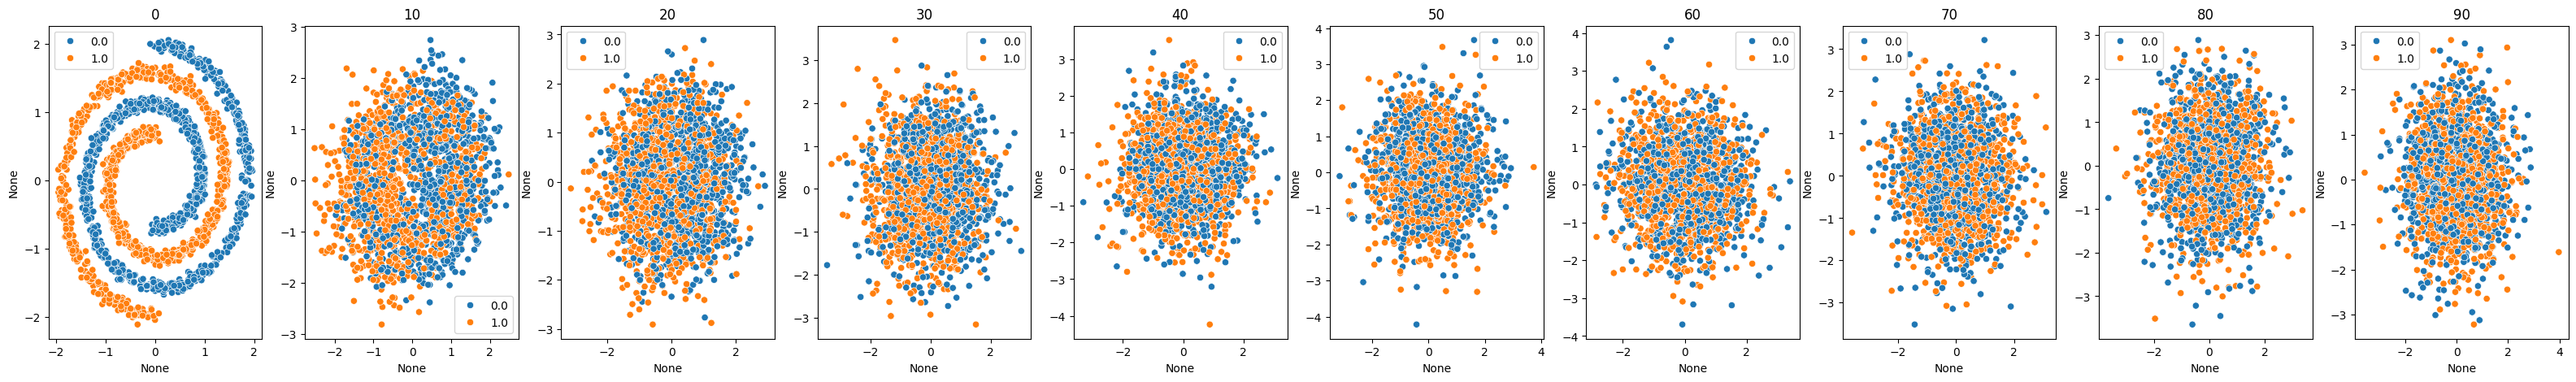

In [27]:
show_noising(diffusion, X, y)

### Модель (0.1 балл из 0.6 за DDPM)

Тут мы реализуем модель с весами $\theta$, которая параметризует обратный процесс. Модель не должна быть сложной и большой. Достаточно только линейных слоев. Не забудьте учесть классы $y$ и шаги $t$. Модель предсказывает шум $\epsilon: \epsilon_{\theta}(x_t, t, y)$

In [43]:
class DiffModel(nn.Module):
    def __init__(self, d_in, num_classes=2):
        super().__init__()

        self.hidden = 128

        # one may use a simple model that projects x and t into space of size self.hidden
        # transforms y label into space of size self.hidden (nn.Embedding), sum all the vectors and postprocess it with MLP
        # try SiLU?? stonks

        self.x_proj = nn.Linear(d_in, self.hidden) # todo
        self.t_proj = nn.Linear(1, self.hidden) # todo
        self.y_embed = nn.Embedding(num_classes, self.hidden) # todo
        self.layers = nn.Sequential(
            nn.Linear(self.hidden, self.hidden),
            nn.SiLU(),
            nn.Linear(self.hidden, self.hidden),
            nn.SiLU(),
            nn.Linear(self.hidden, d_in)
        ) # todo

    def forward(self, x, t, y):
        '''
        :x input, e.g. images
        :t 1d torch.LongTensor of timesteps
        :y 1d torch.LongTensor of class labels
        '''
        # todo
        # print(x.dtype, t.dtype, y.dtype)
        # print(f"x, t, y shapes: {x.shape, t.shape, y.shape}")
        x = self.x_proj(x)
        # print(f"x: {x_.shape} ")
        t = self.t_proj(t.unsqueeze(-1).float())
        # print(f"t: {t_.shape} ")
        y = self.y_embed(y)
        # print(f"t: {t_.shape} ")
        out = x + t + y

        return self.layers(out)

### Обучение модели (0.1 балл из 0.6 за DDPM)

Наконец, обучим нашу модель. Ниже за вас написан класс `Trainer`, который хранит модель, диффузию и оптимайзер. Вам надо лишь дописать функцию `_run_step`

In [44]:
from copy import deepcopy

import pandas as pd


class Trainer:
    def __init__(
        self,
        diffusion: Diffusion,
        model: nn.Module,
        train_iter,  # iterable that yields (x, y)
        lr: float,
        weight_decay: float,
        steps: int,
        device: torch.device = torch.device("cpu"),
    ):
        self.diffusion = diffusion

        self.train_iter = train_iter
        self.steps = steps
        self.init_lr = lr
        self.model = model
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(), lr=lr, weight_decay=weight_decay
        )
        self.device = device
        self.log_every = 100
        self.print_every = 500

    def _anneal_lr(self, step: int):
        """
        Performs annealing of lr.
        """

        frac_done = step / self.steps
        lr = self.init_lr * (1 - frac_done)
        for param_group in self.optimizer.param_groups:
            param_group["lr"] = lr

    def _run_step(self, x: torch.FloatTensor, y: torch.LongTensor):
        """
        A single training step.
        Calculates loss (using Diffusion.train_loss() )for a single batch.
        Then performs a single optimizer step (don't forget to zero grad) and returns loss.
        """
        # todo
        # zero_grad, calc loss, backw
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        loss = self.diffusion.train_loss(self.model, x, y)
        loss.backward()
        self.optimizer.step()

        return loss

    def run_loop(self):
        """
        Training loop.
        """
        step = 0
        curr_loss_gauss = 0.0

        curr_count = 0
        while step < self.steps:
            x, y = next(self.train_iter)
            batch_loss = self._run_step(x, y)

            self._anneal_lr(step)

            curr_count += len(x)
            curr_loss_gauss += batch_loss.item() * len(x)

            if (step + 1) % self.log_every == 0:
                gloss = np.around(curr_loss_gauss / curr_count, 4)
                if (step + 1) % self.print_every == 0:
                    print(f"Step {(step + 1)}/{self.steps} Loss: {gloss}")
                curr_count = 0
                curr_loss_gauss = 0.0

            step += 1

Теперь обернем наши данные в `DataLoader`. Для этого за вас написан `FastTensorDataLoader`. Также у нас идет обучение не по эпохам, а по итерациям, поэтому нам нужен "бесконечный" итератор.

In [45]:
from utils import FastTensorDataLoader


def get_data_iter(X: np.ndarray, y: np.ndarray, batch_size: int = 512):
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).long()
    dataloader = FastTensorDataLoader(X, y, batch_size=batch_size, shuffle=True)
    while True:
        yield from dataloader


data_iter = get_data_iter(X, y)

In [46]:
# you can change hyperparameters
model = DiffModel(d_in=2)
model.device = torch.device("cuda")  # достаточно cpu
trainer = Trainer(
    diffusion, model,
    train_iter=data_iter,
    lr=0.01,
    weight_decay=0.0,
    steps=30000
)

In [47]:
trainer.run_loop()  # < 1min

Step 500/30000 Loss: 0.2796
Step 1000/30000 Loss: 0.2638
Step 1500/30000 Loss: 0.2624
Step 2000/30000 Loss: 0.2598
Step 2500/30000 Loss: 0.2608
Step 3000/30000 Loss: 0.2586
Step 3500/30000 Loss: 0.251
Step 4000/30000 Loss: 0.2549
Step 4500/30000 Loss: 0.2807
Step 5000/30000 Loss: 0.2667
Step 5500/30000 Loss: 0.2588
Step 6000/30000 Loss: 0.2545
Step 6500/30000 Loss: 0.2522
Step 7000/30000 Loss: 0.2528
Step 7500/30000 Loss: 0.2561
Step 8000/30000 Loss: 0.2563
Step 8500/30000 Loss: 0.2568
Step 9000/30000 Loss: 0.2476
Step 9500/30000 Loss: 0.2543
Step 10000/30000 Loss: 0.2465
Step 10500/30000 Loss: 0.2477
Step 11000/30000 Loss: 0.2495
Step 11500/30000 Loss: 0.2425
Step 12000/30000 Loss: 0.2441
Step 12500/30000 Loss: 0.2425
Step 13000/30000 Loss: 0.2438
Step 13500/30000 Loss: 0.2449
Step 14000/30000 Loss: 0.2423
Step 14500/30000 Loss: 0.237
Step 15000/30000 Loss: 0.2407
Step 15500/30000 Loss: 0.2371
Step 16000/30000 Loss: 0.2421
Step 16500/30000 Loss: 0.2415
Step 17000/30000 Loss: 0.2386
St

Теперь насэмплируем данные из нашей модели

In [48]:
from typing import List, Tuple


def sample_synthetic(
    diffusion: Diffusion,
    model: nn.Module,
    num_samples: int,
    batch: int = 1000,
    shape: Tuple = (2,),
    y_dist: List[float] = [0.5, 0.5],
    ddim: bool = False,
):

    model = model.to('cuda')
    sample_func = diffusion.p_sample_loop
    if ddim:  # for the last task
        sample_func = diffusion.ddim_sample
    res_x = []
    res_y = []
    num_sampled = 0
    while num_sampled < num_samples:
        x, y = diffusion.p_sample_loop(
            model, shape=(batch, *shape), y_dist=torch.tensor(y_dist)
        )
        res_x.append(x.cpu())
        res_y.append(y.cpu())
        num_sampled += batch

    res_x = torch.cat(res_x, dim=0)
    res_y = torch.cat(res_y, dim=0)
    return res_x[:num_samples], res_y[:num_samples]

In [49]:
Xs, ys = sample_synthetic(diffusion, model, 1000)

100%|██████████| 100/100 [00:00<00:00, 682.43it/s]


<Axes: xlabel='None', ylabel='None'>

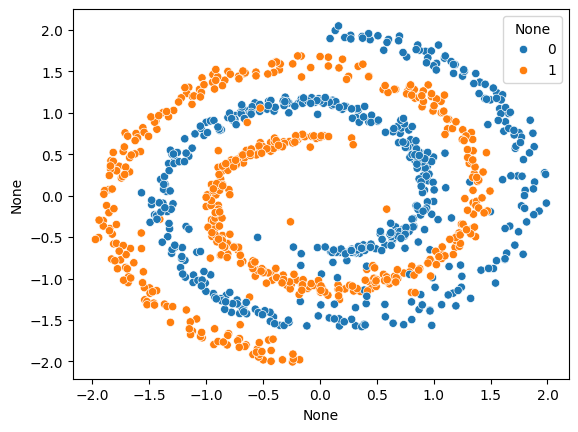

In [50]:
sns.scatterplot(x=Xs[:, 0], y=Xs[:, 1], hue=ys)

Оцените на глаз, что получилось (должно быть неплохо). Как можно численно оценить качество насэмплированных данных (именно этих данных)?  Пункт не оценивается.

Покажите процесс расшумления аналагично тому, как мы это делали для прямого процесса

In [73]:
def show_denoising(diffusion, model):
    fig, axs = plt.subplots(1, 10, figsize=(40, 5))
    x = torch.randn(1000, *(2,), device=model.device)
    inds = list(range(diffusion.num_timesteps))[::-1]
    y = torch.multinomial(torch.tensor([0.5, 0.5]), num_samples=1000,
                          replacement=True).to(x.device)
    logs = []

    for i in tqdm(inds):
      t = torch.tensor([i] * 1000, device=x.device)
      with torch.no_grad():
        if i % 10 == 0:
          logs.append((i, x.cpu().numpy(), y.cpu().numpy()))
        out = model(x, t, y)
        out = diffusion.p_sample(
            out,
            x,
            t
        )
        x = out['sample']
    # for i, t in enumerate(range(0, diffusion.num_timesteps, 10)):
    #     x = diffusion.q_sample(
    #         x_start=torch.from_numpy(X),
    #         t=torch.ones_like(torch.from_numpy(y)).long() * t,
    #     )
    for i, (t, x, y) in enumerate(logs):
      sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y, ax=axs[i])
      axs[i].set(title=diffusion.num_timesteps - t)

100%|██████████| 100/100 [00:00<00:00, 727.99it/s]


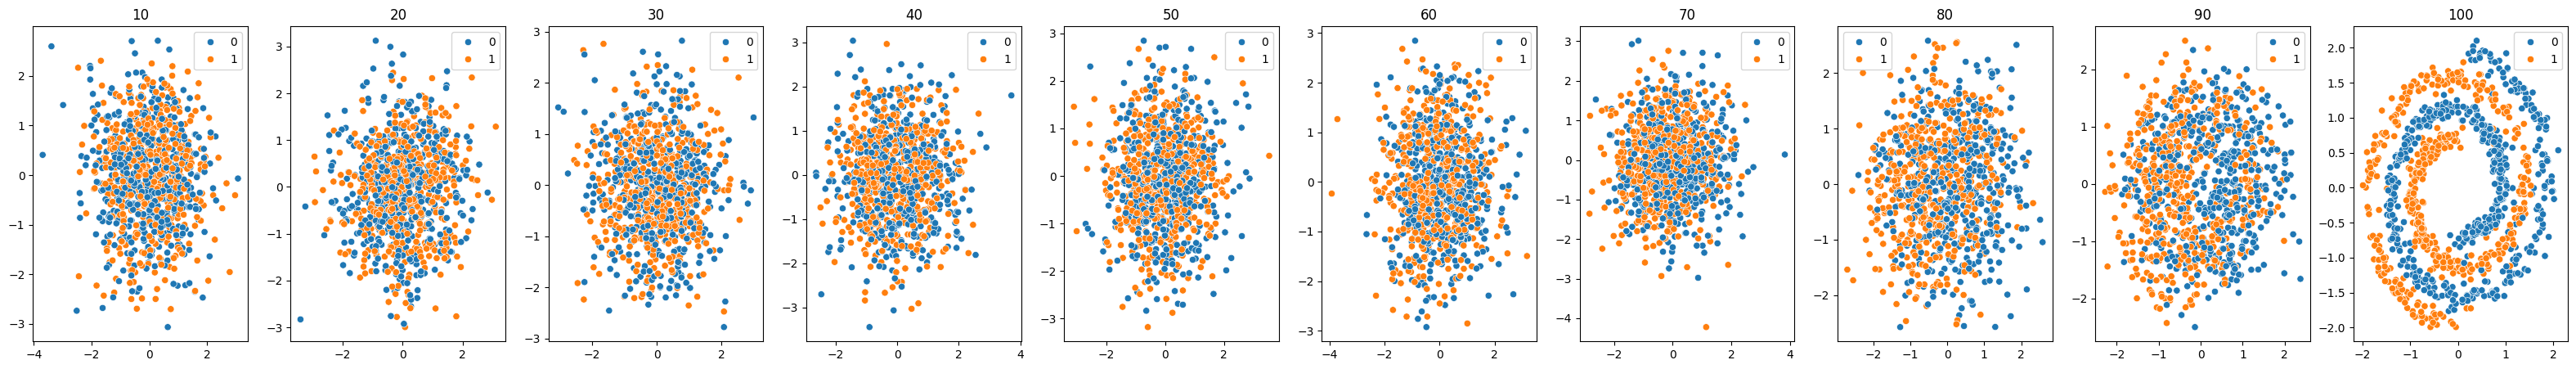

In [74]:
show_denoising(diffusion, model)

## MNIST (0.2 балла)

Перейдём к обучению диффузионной модели на MNIST. За вас уже написана архитектура модели. В данной задаче надо лишь получить относительно *хороший* результат на датасете, используя класс `Diffusion`, а также посмотреть на разные расписания шума.

In [20]:
from torch.utils.data import DataLoader


class InfiniteDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Initialize an iterator over the dataset.
        self.dataset_iterator = super().__iter__()

    def __iter__(self):
        return self

    def __next__(self):
        try:
            batch = next(self.dataset_iterator)
        except StopIteration:
            # Dataset exhausted, use a new fresh iterator.
            self.dataset_iterator = super().__iter__()
            batch = next(self.dataset_iterator)
        return batch

In [21]:
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import Compose, Lambda, Normalize, ToTensor

transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

dataset = MNIST("./datasets", download=True, train=True, transform=transform)
loader = InfiniteDataLoader(dataset, 512, shuffle=True)

In [22]:
def show_images(images, ys, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()
        ys = ys.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                plt.title(f"{int(ys[idx])}")
                plt.tick_params(bottom=False, labelbottom=False)
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()


def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0][:16], batch[1][:16], "Images in the first batch")
        break

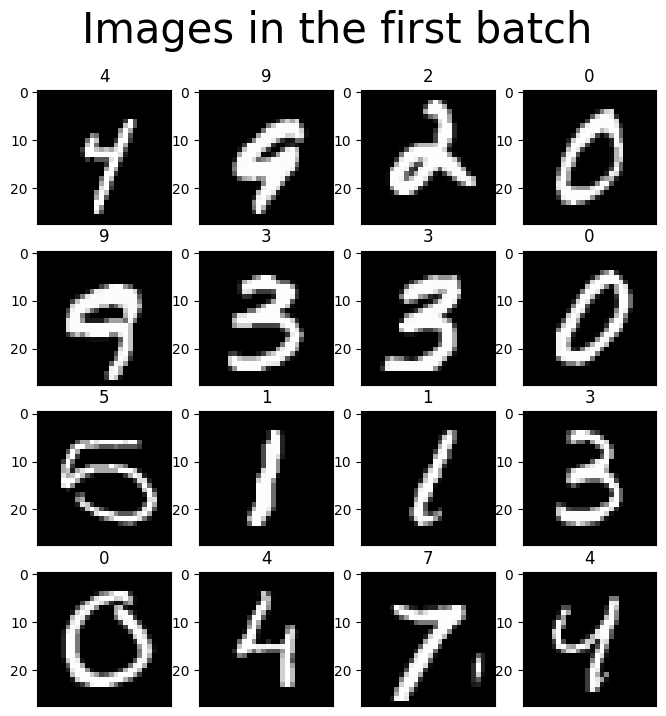

In [28]:
show_first_batch(loader)

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(
    f"Using device: {device}\t"
    + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU")
)

Using device: cuda	Tesla T4


In [30]:
from utils import MyUNet

model_mnist = MyUNet().to(device)
model_mnist.device = device

### Смотрим на расписание шума

Прежде чем начать, постройте на одной картинке графики $\sqrt{\bar{\alpha_t}}$ (относительно $t$) для различных расписаний (linear, quad, sigmoid). Объясните, чем они отличаются. Чтобы лучше это понять визуализируйте зашумление картинок (функция `show_noising_mnist`). Советую выбрать $T = 1000$ (классический выбор, если домен -- картинки). Данный пункт оценивается.

In [31]:
def get_alpha_bar(betas):
    # todo
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    return torch.sqrt(alphas_cumprod)

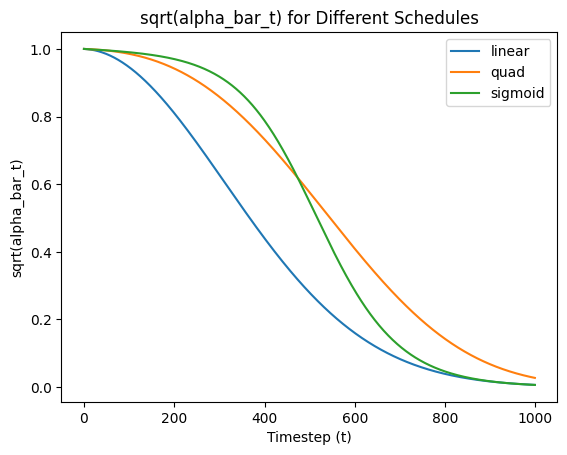

In [32]:
ts = range(1000)

betas_linear = get_named_beta_schedule("linear", len(ts))
betas_quad = get_named_beta_schedule("quad", len(ts))
betas_sigmoid = get_named_beta_schedule("sigmoid", len(ts))

sqrt_alpha_bar_linear = get_alpha_bar(torch.tensor(betas_linear))
sqrt_alpha_bar_quad = get_alpha_bar(torch.tensor(betas_quad))
sqrt_alpha_bar_sigmoid = get_alpha_bar(torch.tensor(betas_sigmoid))

plt.plot(ts, sqrt_alpha_bar_linear.numpy(), label="linear")
plt.plot(ts, sqrt_alpha_bar_quad.numpy(), label="quad")
plt.plot(ts, sqrt_alpha_bar_sigmoid.numpy(), label="sigmoid")
plt.xlabel("Timestep (t)")
plt.ylabel("sqrt(alpha_bar_t)")

plt.legend(["linear", "quad", "sigmoid"])

plt.title("sqrt(alpha_bar_t) for Different Schedules")
plt.show()

In [34]:
# almost the same as in the task with SwissRolls

def show_noising(diffusion, image):
    fig, axs = plt.subplots(1, 10, figsize=(40, 5))
    for i, t in enumerate(range(0, diffusion.num_timesteps, diffusion.num_timesteps // 10)):
        x = diffusion.q_sample(
            x_start=image,
            t=torch.tensor([t]),
        )

        axs[i].imshow(x.reshape(image.shape[1:]), cmap='gray')
        axs[i].set(title=t)

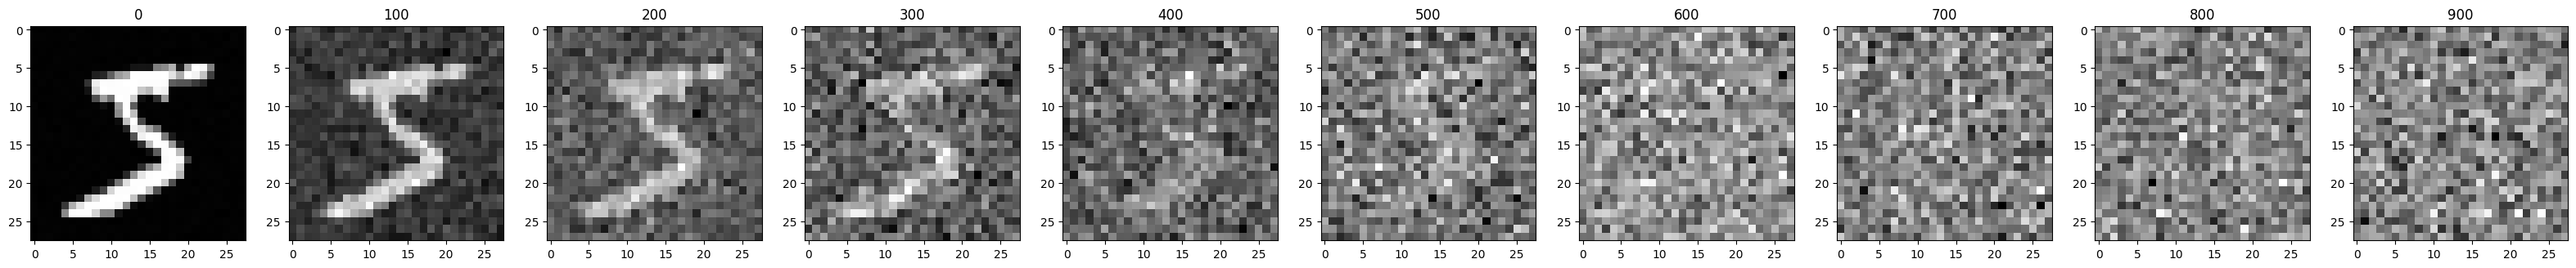

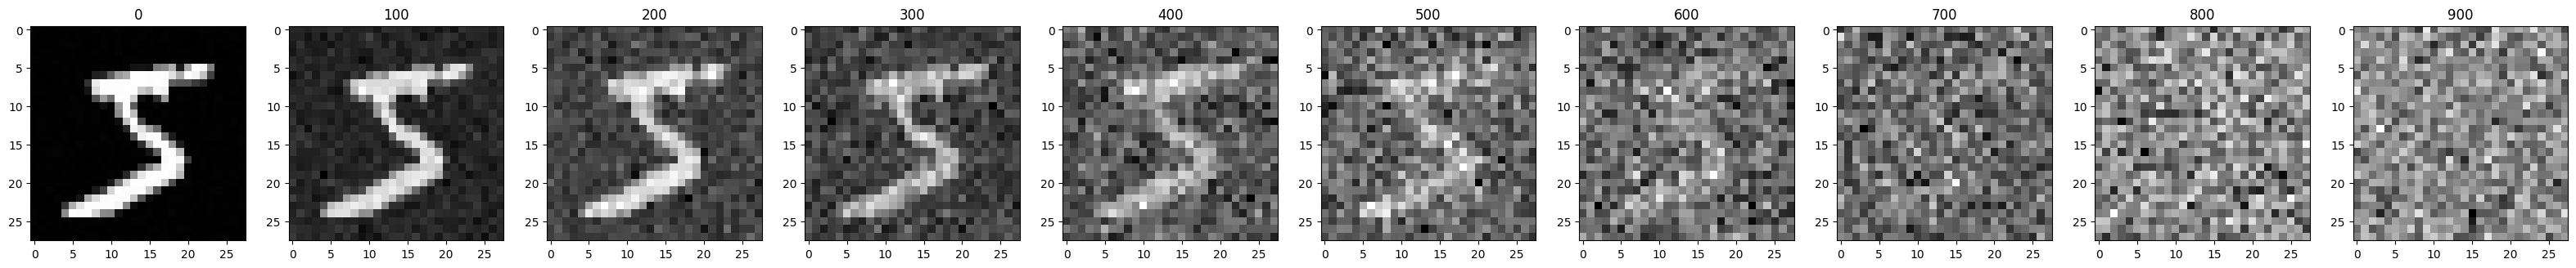

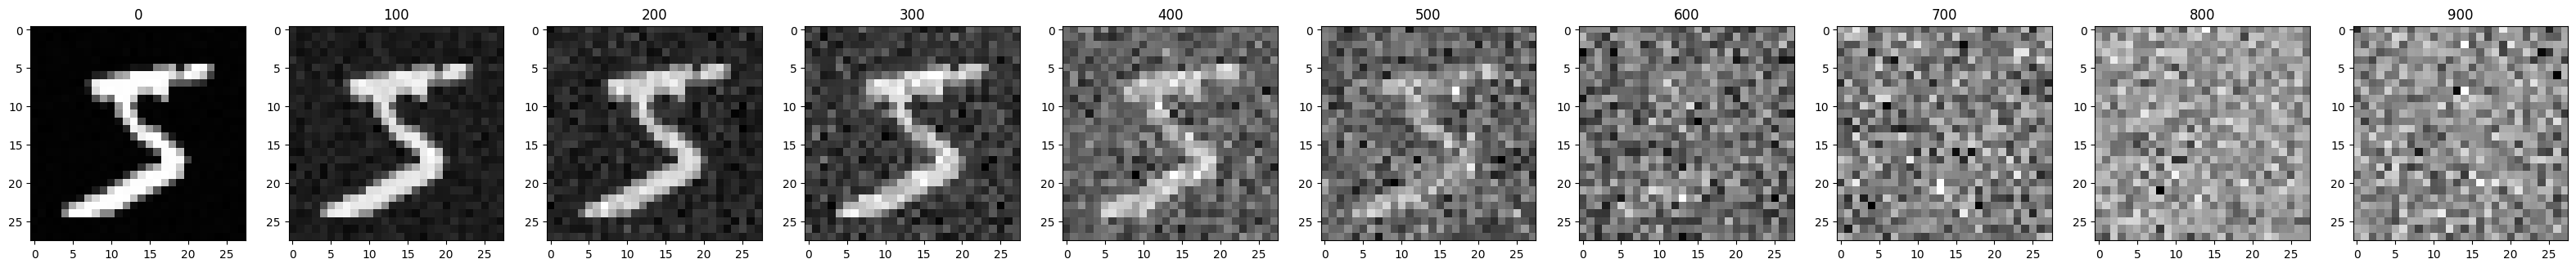

In [35]:
for sch in ["linear", "quad", "sigmoid"]:
    diffusion_temp = Diffusion(
        betas=get_named_beta_schedule(sch, 1000), loss_type="mse"
    )
    show_noising(diffusion_temp, dataset[0][0])

### Обучаем

In [ ]:
scheduler = "quad" # choose your pokemon

diffusion_mnist = Diffusion(
    betas=get_named_beta_schedule(scheduler, 1000),
    loss_type="mse"
)

# feel free to change hyperaparameters

trainer_mnist = Trainer(
    diffusion_mnist,
    model_mnist,
    train_iter=loader,
    lr=0.001,
    steps=2000,
    weight_decay=0.0,
    device=device
)

In [ ]:
trainer_mnist.run_loop()  # <15min on 2080Ti for the author's solution

Step 500/2000 Loss: 0.112
Step 1000/2000 Loss: 0.0821
Step 1500/2000 Loss: 0.0745
Step 2000/2000 Loss: 0.0713


In [ ]:
Xs, ys = sample_synthetic(
    diffusion_mnist,
    model_mnist,
    num_samples=16,
    batch=16,
    shape=(1, 28, 28),
    y_dist=[0.1 for _ in range(10)],
)

100%|██████████| 1000/1000 [00:07<00:00, 135.30it/s]


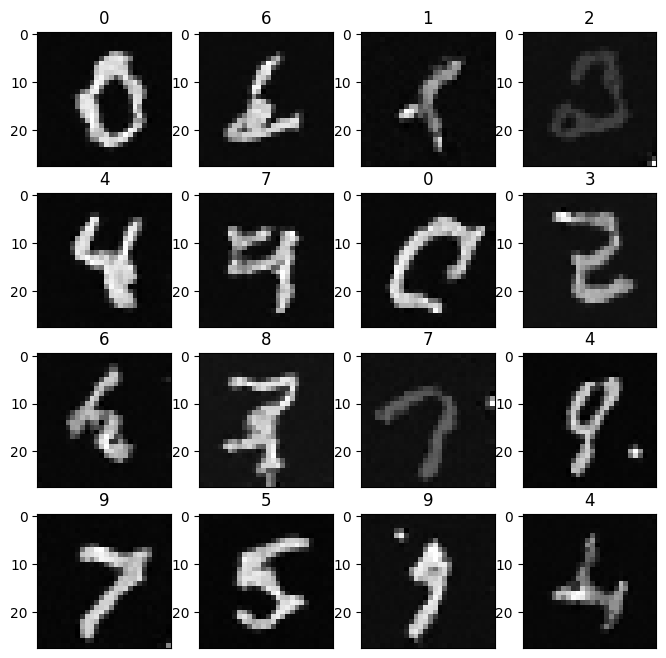

In [ ]:
show_images(Xs, ys)

Оцените качество насэмплированных картинок.
В целом, очертания цифр не совсем ужасные, какие-то можно явно определить, но явно не хватает шагов обучения

## DDIM (0.2 балла)

**ВАЖНО:** В данном задании используется нотация из оригинальной статьи. Она отличается от нотации выше. А именно, считайте, что ниже $\alpha_t := \bar{\alpha}_t$ (в формулах, не в коде). Также $\sigma_t$ ниже тоже отличается (о том, что это, будет написано дальше).

В данной задаче вам предстоит реализовать DDIM сэмплирование. Подробнее читайте тут: [Denoising Diffusion Implicit Models, Song et al., 2020](https://arxiv.org/abs/2010.02502).

Давайте вкратце опишем, в чем смысл. Идея следущая: изменим диффузионный процесс так, чтобы используя предобученную DDPM, обратный процесс был детерминистичен и вследствии его можно было приближать за меньшее число шагов. В данном задании мы не будем ускорять процесс сэмплирования, но реализуем DDIM.

Чтобы не обучать новую модель, нам нужен прямой диффузионный процесс, у которого будет такая же функция потерь (MSE на шум), а обратный процесс все еще останется марковским. Оказалось, что существует целое семейство немарковских прямых процессов, удовлетворяющих этим требования. Это семейство имеет следующий вид (индуцируемое $\sigma \in \mathbb{R}^T$):

![ddim](https://i.imgur.com/lB2KaOR.png)

Среднее распределения выше было выбрано так, чтобы маргинальное распределение $q(x_t | x_0)$ оставалось таким же, как раньше. Это можно проверить, используя формулу Байеса и свойства нормальных распределений.  

То есть мы:
1. Ввели $q_{\sigma}(x_{t - 1} | x_t, x_0)$
2. Ввели его так, чтобы $q(x_t | x_0)$ было как раньше
3. При это прямой процесс становится не марковским $q_{\sigma}(x_t | x_{t - 1}, x_0)$
4. А обратный процесс марковский: $p(x_{t - 1} | x_t) = q_{\sigma}(x_{t - 1} | x_t, \hat{x_0}(x_t, t))$

Тогда обратный процесс можно переписать как $q_{\sigma}(x_{t-1}|x_t, \hat{x}_{0}(x_t))$ или же:

\begin{equation*}
    x_{t-1} = \sqrt{\alpha_{t-1}} \underbrace{\left(\frac{x_t - \sqrt{1 - \alpha_t} \epsilon_\theta^{(t)}(x_t)}{\sqrt{\alpha_t}}\right)}_{\text{`` predicted } x_0 \text{''}} + \underbrace{\sqrt{1 - \alpha_{t-1} - \sigma_t^2} \cdot \epsilon_\theta^{(t)}(x_t)}_{\text{``direction pointing to } x_t \text{''}} + \underbrace{\sigma_t \epsilon_t}_{\text{random noise}}  \quad \quad \quad \quad \quad \quad (8)
\end{equation*}

**Самое важное**:

Теперь давайте скажем, что $\sigma_t(\eta) = \eta\sqrt{(1 - \alpha_{t - 1}) / (1 - \alpha_t)}\sqrt{1 - \alpha_t / \alpha_{t - 1}}$, тогда при $\eta = 1$ равенство (8) превращается в DDPM сэмплирование. При $\eta = 0$ у нас $\sigma_t = 0$ и пропадает третья компонента стохастичности, что и называется DDIM сэмплирование. Таким образом, у нас есть детерминистичный процесс сэмплирования: при заданном начальном латенте мы всегда насэмлируем один и тот же $x_0$. Также можно достичь ускорения сэмплирования, выбирая лишь подмножество шагов $0 \leq \tau_1 \leq ... \leq \tau_S \leq T, \ \ \ S < T$ и сэмплируя с помощью DDIM по ним.

Итак, ниже вам придется реализовать прямой DDIM. Важно отметить, что нам не нужно переучивать модель, чтобы пользоваться DDIM.

In [ ]:
class DiffusionWithDDIM(Diffusion):
    def __init__(self, *args, **kwargs):
        super(DiffusionWithDDIM, self).__init__(*args, **kwargs)

    @torch.no_grad()
    def ddim_step(
        self,
        model_out: torch.FloatTensor,
        x: torch.FloatTensor,
        t: torch.LongTensor,
        eta: float = 0.0
    ):
        """
        Performs ddim step. Use equation (8).
        """

        eps = model_out

        alpha_bar = _extract_into_tensor(self.alphas_cumprod, t, x.shape) # todo
        alpha_bar_prev = _extract_into_tensor(self.alphas_cumprod_prev, t, x.shape) # todo
        sigma = eta * torch.sqrt((1.0 - alpha_bar_prev) / (1.0 - alpha_bar)) * \
                torch.sqrt(1.0 - alpha_bar / alpha_bar_prev) # todo

        noise = torch.randn_like(x)
        mean_pred = torch.sqrt(alpha_bar_prev) * (x - torch.sqrt(1.0 - alpha_bar) * eps) / torch.sqrt(alpha_bar) + \
                    torch.sqrt(1.0 - alpha_bar_prev - sigma ** 2) * eps # todo
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        ) # todo, no noise when t == 0
        sample = mean_pred + nonzero_mask * sigma * noise

        return sample

    @torch.no_grad()
    def ddim_sample(
        self,
        model: nn.Module,
        shape: Tuple,
        y_dist: torch.FloatTensor,
        y: torch.LongTensor = None,
        noise: torch.FloatTensor = None,
        eta: float = 0.0
    ):
        """
        Performs ddim sampling.
        """
        if noise is None:
            x = torch.randn(shape)
        else:
            x = noise

        b = x.shape[0]
        if y is None:
            y = torch.multinomial(
                y_dist,
                num_samples=shape[0],
                replacement=True
            )

        device = x.device
        for t in reversed(range(self.num_timesteps)):
            print(f'Sample timestep {t:4d}', end='\r')
            t_array = (torch.ones(b, device=device) * t).long()
            model_out = model(x, t_array, y)
            x = self.ddim_step(
                model_out,
                x,
                t_array,
                eta=eta
            )
        print()
        return x

In [ ]:
diffusion_ddim = DiffusionWithDDIM(
    betas=get_named_beta_schedule(scheduler, 1000), loss_type="mse"
)

Теперь насэмплируем детерминистично (eta = 0).

In [ ]:
noise = torch.randn((16, 1, 28, 28))
Xs_new = diffusion_ddim.ddim_sample(
    model_mnist,
    shape=(1, 28, 28),
    y_dist=torch.tensor([0.1] * 10),
    y=ys.to(model_mnist.device),
    noise=noise.to(model_mnist.device),
)

Sample timestep    0


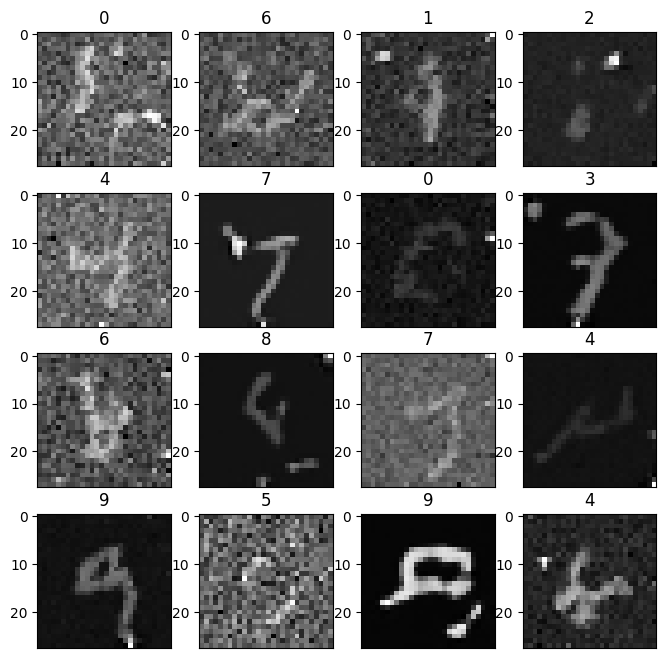

In [ ]:
show_images(Xs_new, ys)

Оцените полученные сэмплы. DDIM хуже DDPM?
либо ошибка в реализации либо сильно хуже